In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from __init__ import *

utils.rng.set_seed()
device = utils.gpu.set_devices(0)

In [3]:
from scipy.special import erf, erfinv, erfc, digamma, gamma
from scipy.special import beta as betaf
from scipy.stats import (
    exponnorm, lognorm, skewnorm, beta, expon, norm, 
    fisk, betaprime, kstest, dirichlet
)
import scipy.optimize as opt


### Softmax-Dirichlet Transform

In a semi-unitary network we are restricted by invertible activation functions, which prevents the models from approximating multinomial and categorical distributions. This is increasingly problematic for classification tasks. Solutions involving approximating a Dirichlet distribution in the latent space is only marginally valuable, as most reparameterization transforms are applied to the concentration parameters, and are not injective. In fact, almost every reparametrization trick involves some use of the softmax function.

Ideally then we then want some invertible approximation to a Softmax function. A direct inversion is clearly impossible, considering that 

$$
\text{softmax}(Z_i) = \frac{\exp(Z_i)}{\sum_j \exp(Z_j)}
$$

where each variable is normalized over a sum, which is lost. However, there might be a way to circumvent this problem. Let $Z_i \sim \mathcal N(0,1)$. Then $\exp(Z_i)$ is log-normally distributed. We then need to find an appropriate distribution for $\sum_j \exp(Z_j)$. A result popularized by Marlow [[1]](https://ieeexplore.ieee.org/document/6771360) gives that $\sum_j \exp(Z_j) \sim \text{LogNormal}$ with parameters

$$
\begin{align}
\sigma_S^2 = \ln\bigg(\frac{e - 1}{k} + 1\bigg) \\
\mu_S = \ln(k) + \frac{1-\sigma_S^2}{2}.
\end{align}
$$



The idea is to approximate the normalizing constant via this approximation. Considering a vector $z \in \mathbb R^k$ of i.i.d. standard normal variables, we allocate $z_1$ as a normalizing constant, and letting

$$
\ln(S) = z_i \sigma_S + \mu_S.
$$ 

This might at first seem a little strange, as for $S$ to act as a normalizing constant, we would require $\exp(z_1) = S - \sum_{j>1} \exp(z_j)$ so $S > \sum_{j>1} \exp(z_j)$. We have no guarantee for this, and normalization would transform the distribution such that we no longer have normality in $z$. However, we are initially more concerned with our ability to sample from a Softmax basis and find a transform which is approximately standard normal, and we will return to the issue of normalization later.

Our first priority is to verify that the approximation by Marlow is sufficiently accurate for our purposes. We implement two functions to calculate parameters, as well as one softmax implementation, and compare the distribution of the normalization constant of standard normal variables in the softmax basis as well as the log-normal approximation. Lastly, we sample from a log-normal and provide metrics for the approximation.

In [4]:
kwargs = {
    'bins': 250,
    'density': True,
    'alpha': 0.6,
}

def sumln_params(mu, std):
    '''Calculates the parameters for the sum of log-normals approximation.
    
    Assumes uniform variance.
    
    Popularized by Marlow, 1967, Ref: https://ieeexplore.ieee.org/document/6771360
    '''
    part1 = np.exp(std**2) - 1
    part2 = np.sum(np.exp(2*mu)) / (np.sum(np.exp(mu))**2)
    var_S = np.log(part1 * part2 + 1)
    mu_S = np.log(np.sum(np.exp(mu))) + std**2/2 - var_S/2
    return mu_S, np.sqrt(var_S)


def sumln_params_center(mu, std):
    '''Calculates the parameters for a centered sum of log-normals approximation.
    
    Assumes uniform variance and centered normal distributions, a simplified version.
    
    Popularized by Marlow, 1967, Ref: https://ieeexplore.ieee.org/document/6771360
    '''
    part1 = np.exp(std**2) - 1
    part2 = 1 / k
    var_S = np.log(part1 * part2 + 1)
    mu_S = np.log(k) + std**2/2 - var_S/2
    return mu_S, np.sqrt(var_S)


def softmax(z):
    '''An implementation of the softmax funtion.
    '''
    return np.exp(z) / np.sum(np.exp(z), axis=-1)[:,None]


def softmax_normalizer(z):
    '''Retrives the normalization constant of the softmax funtion.
    '''
    return np.sum(np.exp(z), axis=-1)[:,None]


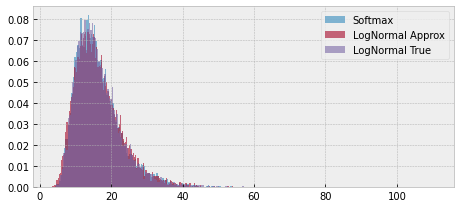

In [5]:
# Assuming standard normal distributions
original_sd = 1
k = 10
n = 10000
mu_S, sd_S = sumln_params_center(k, original_sd)

# Sample standard normals
z = np.random.randn(n, k)
S_sm = softmax_normalizer(z)

# Sample lognormal approximations
S_ln = np.random.lognormal(mean=mu_S, sigma=sd_S, size=(n,1))

# Sample standard lognormals and compute their sum
S_ac = np.sum(np.random.lognormal(sigma=original_sd, size=(n,k)), axis=-1)

# Plot
plt.hist(S_sm, label='Softmax', **kwargs)
plt.hist(S_ln, label='LogNormal Approx', **kwargs)
plt.hist(S_ac, label='LogNormal True', **kwargs)
plt.legend();
plt.savefig(f'../figures/misc/marlow_transform_k{k}.pdf')
plt.tight_layout()

In [6]:
# Kolgomorov-Smirnov two sided test

s_smln, p_smln = kstest(S_sm[0], S_ln[0])
s_acln, p_acln = kstest(S_sm[0], S_ln[0])

print(f'Kolgomorov Smirnov Two Sided Test')
print(f'Softmax   vs. LogNormal Approx. - stat: {s_smln}  p: {p_smln}')
print(f'LogNormal vs. LogNormal Approx. - stat: {s_acln}  p: {p_acln}')

Kolgomorov Smirnov Two Sided Test
Softmax   vs. LogNormal Approx. - stat: 1.0  p: 1.0
LogNormal vs. LogNormal Approx. - stat: 1.0  p: 1.0


The Marlow approximation is more than accurate enough for our purposes. Thus we have a way of sampling the normalization constant $S$. The next step is to be able to sample from the softmax basis of a set of standard normal variables. The softmax basis acts as a weak prior for a categorical / multinomial distributions in neural classifiers. The canonical prior for these distributions is a symmetrical Dirichlet, with some non-informative prior distribution, so a natural choice would be Jeffreys prior given by

$$
Y \sim \text{SymDirichlet}(.5, k),
$$

or some other parametrization matching the softmax basis. MacKay [[3]](https://link.springer.com/article/10.1023/A:1007558615313) suggests using the parametrization $\alpha = 1$. We will briefly compare both parametrizations. Note that since $Y$ is symmetrically Dirichlet, it is for all practical purposes a multinomial beta distribution, thus we have $Y_i \sim B(\alpha, (k-1)\alpha)$.

SM   min: 0.0000 SM   max: 0.4156
Beta min: 0.0000 Beta max: 0.1232
Dir  min: 0.0000 Dir  max: 0.1376


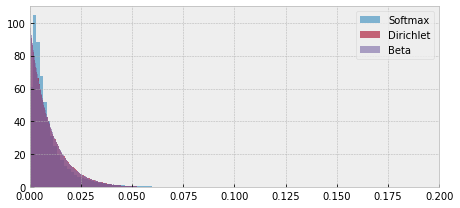

In [7]:
# Assign parameters
k = 100
a = 1

# Sample Normal
z = np.random.randn(n, k)
y_sm = softmax(z).reshape(k*n)

# Sample Symmetrical Dirichlet
y_d = np.random.dirichlet([a] * k, size=n).reshape(k*n)

# Sample individual Beta
y_b = np.random.beta(a, (k - 1) * a, size=(n, k)).reshape(k*n)

plt.hist(y_sm, label='Softmax', **kwargs)
plt.hist(y_d, label='Dirichlet', **kwargs)
plt.hist(y_b, label='Beta', **kwargs)
plt.xlim(0, 0.2)
plt.legend();
plt.savefig(f'../figures/misc/dirichlet_softmax_beta_approx_k{k}_a{a}.pdf')
plt.tight_layout()
print(f'SM   min: {min(y_sm):6.4f} SM   max: {max(y_sm):6.4f}')
print(f'Beta min: {min(y_b):6.4f} Beta max: {max(y_b):6.4f}')
print(f'Dir  min: {min(y_d):6.4f} Dir  max: {max(y_d):6.4f}')

SM   min: 0.0001 SM   max: 0.5526
Beta min: 0.0000 Beta max: 0.2333
Dir  min: 0.0000 Dir  max: 0.2003


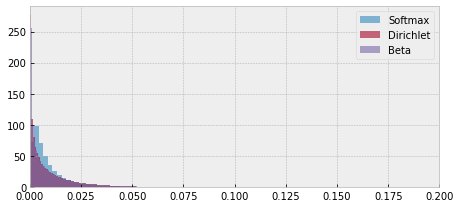

In [8]:
# Assign parameters
k = 100
a = .5

# Sample Normal
z = np.random.randn(n, k)
y_sm = softmax(z).reshape(k*n)

# Sample Symmetrical Dirichlet
y_d = np.random.dirichlet([a] * k, size=n).reshape(k*n)

# Sample individual Beta
y_b = np.random.beta(a, (k - 1) * a, size=(n, k)).reshape(k*n)

plt.hist(y_sm, label='Softmax', **kwargs)
plt.hist(y_d, label='Dirichlet', **kwargs)
plt.hist(y_b, label='Beta', **kwargs)
plt.legend();
plt.savefig(f'../figures/misc/dirichlet_softmax_beta_approx_k{k}_a{a}.pdf')
plt.tight_layout()
plt.xlim(0, 0.2);
print(f'SM   min: {min(y_sm):6.4f} SM   max: {max(y_sm):6.4f}')
print(f'Beta min: {min(y_b):6.4f} Beta max: {max(y_b):6.4f}')
print(f'Dir  min: {min(y_d):6.4f} Dir  max: {max(y_d):6.4f}')

The beta and Symmetric Dirichlet distributions are seemingly equal, however they do not necessarily approximate the softmax basis, or equivalently; the approximation for $\alpha=1$ is not extremely accurate. The softmax basis is seemingly more skewed, with a mode above 0, while the modes of the Dirichlet and beta distributions fall at 0. This intuitively corresponds with the Dirichlet prior being more conservatively objective while the softmax basis adds slighly more positive bias. 

There might be better parametrizations if we drop the assumption of symmetry, i.e. uniform likelihood across the simplex, however this does not align with the Dirichlet acting as a non-informative prior. We also note that when $k$ increases, the distributions align slightly better, but as $k$ is not strictly a hyperparameter, this observation is of dubious value.

#### Naive Approximation

As a start-off point, we would like to determine how well a naive transformation of a vector $Y \sim \text{SymDirichlet}(\alpha, k)$ can approximate a standard normal distribution. We apply the transformation

$$
Z_i \approx \ln(Y_i) + \ln(S)
$$

without expecting much in terms of goodness of fit. From the original idea, we have however alloceted one of our latent variables to $S$. This is unproblematic, as $Y_i = 1 - \sum_j Y_j$, but it requires us to sample $k-1$ out of the total $k$ dimensional Dirichlet vector. A well known result gives a sampling procedure a Dirichlet by

$$
\begin{align}
U_i &\sim B(\alpha, (k-i)\alpha) \\
Y_i &= U_i\bigg(1 - \sum_j Y_{j<i}\bigg),
\end{align}
$$

however this is less popular and computationally effective than sampling via Gamma distributed variables and simply normalizing. However, the method outlined above can be more effectively computed via vectorization. Note that for the initial components, we have

$$
\begin{align}
Y_1 &= U_1 \\
Y_2 &= U_2(1-U_1) \\
Y_3 &= U_3(1-U_1)(1-U_2) \\
Y_4 &= U_4(1-U_1)(1-U_2)(1-U_3)\\
\dots
\end{align}
$$

so the generalization given by

$$
\begin{align}
Y_i &= U_i \prod_{j<i} (1 - U_j) 
\end{align}
$$

is more appropriate in terms of computation. We will also utilize this simplification later, as this is more appropriate for applications in machine learning libraries, which make heavy use of vectorized computations.

In [9]:
def symdirchlet_beta_sampling(a, k, size=1):
    ''' Function to sample k-1 values from a k-dimensional Dirichlet.
    '''
    # Prepare parameters
    _as = a * np.ones((size, (k-1)))
    _bs = a * np.arange(k-1, 0, -1)

    # Sample betas
    betas = np.random.beta(_as, _bs)
    
    # Create Dirichlet
    dirch = np.zeros_like(betas)
    dirch[:,0] = betas[:,0]
    dirch[:,1:] = np.cumprod(1-betas[:,:-1], axis=-1) * betas[:,1:]
    
    return dirch


def get_last_symdirichlet(d):
    '''Retrieves last sample of a Symmetric Dirichlet and concatenates the result.
    '''
    dlast = 1 - np.sum(d, axis=-1)
    return np.hstack([d, dlast[:,None]])
    

In [10]:
# Set parameters
a = 0.5
k = 5
n = 10000

# Sample symmetric Dirichlet
y = symdirchlet_beta_sampling(a, k, size=n)
y = get_last_symdirichlet(y)

# Sample actual Dirichlet
y0 = np.random.dirichlet([a] * k, size=n)

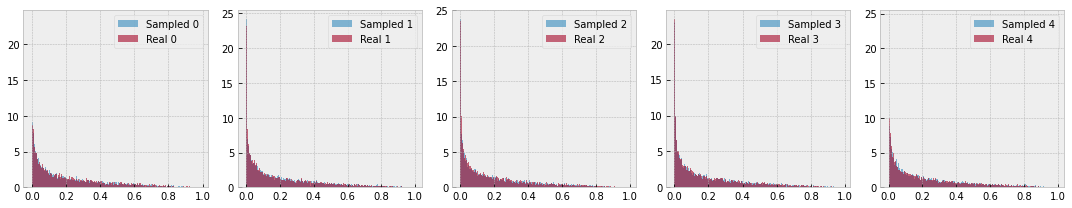

In [11]:
fig, ax = plt.subplots(1, k, figsize=(3*k, 3))

for i in range(k):
    ax[i].hist(y[:,i], label=f'Sampled {i}', **kwargs)
    ax[i].hist(y0[:,i], label=f'Real {i}', **kwargs)
    ax[i].legend();
plt.savefig(f'../figures/misc/sample_beta_dirichlet_approx_k{k}_a{a}.pdf')
plt.tight_layout()

In [12]:
%%timeit -n 100
symdirchlet_beta_sampling(a, k, size=n);

6.96 ms ± 303 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [13]:
%%timeit -n 100
np.random.dirichlet([a] * k, size=n);

5.95 ms ± 224 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


The sampling procedure seems to be working as expected, and although it is marginally slower than the numpy implementation, it is sufficiently effective to use in more computationally heavy tasks. The point is that we want an implementation where we can rather quickly transform beta distributed variables to a proper Dirichlet form. 

We now want to apply the naive inverse Softmax transform, and see how well it approximates the standard normal distribution. Note that since we are using $\ln(S)$ we can equivalently sample from a standard normal distribution instead. To retrieve $Z_k$ we need to perform the transformation given by

$$
\begin{align}
Y_k = \frac{\exp(Z_k)}{S} &= 1 - \sum_{j<k} \frac{\exp(Z_j)}{S} \\
\exp(Z_k) &= S - \sum_{j<k} \exp(Z_j) \\
Z_k &= \ln\bigg(S - \sum_{j<k} \exp(Z_j)\bigg),
\end{align}
$$

however - as mentioned earlier - we emphasize that there is no guarantee that $S > \sum_{j<k} \exp(Z_j)$, thus this method is likely to give invalid outputs. Instead we can simply retrieve $Y_k$ as previously and apply the same transformation as the other values.

In [14]:
def get_last_normal(z, S):
    '''Retrieves last sample of a standard normal using the naive softmax inversion.
    
    NOTE: This method is likely to fail forward as S is not necessarily greater than the sum of the lognormals.
    '''
    z_k = np.log(S - np.sum(z, axis=-1)[:,None])
    return np.hstack([z, z_k])

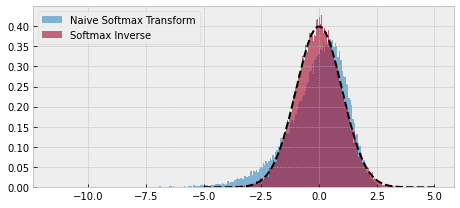

In [15]:
# Set parameters
a = 1
n = 5000
k = 10

# Sample standard normal and transform
S = np.random.randn(n, 1) * sd_S + mu_S

# Sample Dirichlet
y = symdirchlet_beta_sampling(a, k, size=n)
y = get_last_symdirichlet(y)

# Naive Inverse Softmax
z_dir = np.log(y) + S

# Sample standard normals
z_sn = np.random.randn(n, k)

# Apply softmax
S_z = softmax_normalizer(z_sn)
z_sn = np.log(softmax(z_sn)) + np.log(S_z)

# Plot approximations and PDF of standard normal
plt.hist(z_dir.reshape(k * n), label='Naive Softmax Transform', **kwargs)
plt.hist(z_sn.reshape(k * n), label='Softmax Inverse', **kwargs)
_x = np.linspace(-5, 5, 1000)
plt.plot(_x, norm.pdf(_x), '--', color='black')

plt.legend();
#plt.savefig(f'./figures/naive_softmax_approx_k{k}_a{a}.pdf')
plt.tight_layout()

The result is a little better than expected, but the distribution is negatively skewed. This is a result of the difference between the Dirichlet distribution and the softmax basis of the normal distribution we observed earlier. To deal with this issue, we need a bijective transform from beta distributed variables to the standard normal distribution.

#### Wise Transform

Wise [[2]](https://www.jstor.org/stable/2332968?refreqid=excelsior%3A329f0870c1198a10be3ad23a45f95e41&seq=1#metadata_info_tab_contents) provides a neat transformation to approximate a normal distribution from Beta distributed random variables. Let $Y_i \sim B(\alpha,\beta)$. Then $(-\ln(Y_i))^{1/3} \approx \mathcal N(\mu_b, \sigma_b)$. The idea is a refinement of an earlier idea by Kimball and Leach by relating the CDF of the Beta distribution $I_x(a, b)$ to the Chi-squared distribution, and applying a normalization using what Wise terms the Wilson-Hilferty transformation, a cube root transform. This yields the approximation

$$
\begin{align}
Z_i = -3\sqrt{\beta}\bigg(1-\frac{1}{9\beta}\bigg)+3\big(-\ln(Y_i)\big)^{1/3}\Bigg[ N\sqrt{\beta}\bigg(1 - \frac{(\beta-1)(\beta+\frac{1}{3})}{12N^2} \bigg)\Bigg],
\end{align}
$$

where $N = \alpha + \frac{\beta}{2} - \frac{1}{2}$. The errors are proportional to $(\beta/N)^4$ for $\alpha \geq \beta$. For $\alpha < \beta$ simply use the symmetry property $1-Y_i \sim B(\beta,\alpha)$. Wise provides an estimate of the mean, given by

$$
\begin{align}
E\Big[\big(-\ln(Y_i)\big)^{1/3}\Big] = \beta^{1/3}\bigg(1-\frac{1}{9\beta}\bigg)\bigg(N - \frac{(\beta-1)(\beta+\frac{1}{3})}{12N} \bigg).
\end{align}
$$

The standard deviation is only provided up to proportionality however, and is given as

$$
\begin{align}
\mathrm{Var}\Big[\big(-\ln(x)\big)^{1/3}\Big] \propto \beta^{-2/6} N^{-2/3}.
\end{align}
$$

This can be easily verified by sampling, while also providing certain goodness-of-fit measures for the approximation.

In [16]:
def wise_transform(y):
    '''Applies the Wise transform on a Beta distributed random variable. 
    '''
    return np.cbrt(-np.log(y))

def wise_mean(a, b):
    '''Calculates the mean of the Wise transform. 
    '''
    N = a + b/2 - 1/2
    part1 = np.cbrt(b) * (1 - 1/(9 * b)) 
    part2 = 1 / np.cbrt(N - (b - 1) * (b + 1/3) / (12 * N**2))
    return part1 * part2

def prop_wise_sd(a, b):
    '''Calculates the proportional standard deviation of the Wise transform. 
    '''
    N = a + b/2 - 1/2
    return 1 / (b**(1/6) * N**(1/3))


In [17]:
S = np.random.randn(n, 1) * sd_S
z_w = wise_transform(1 - y) 
z_ws = (z_w - wise_mean((k-1) * a, a)) / (0.315 * prop_wise_sd((k-1) * a, a)) + S

In [18]:
sd_S

0.39820230880851143

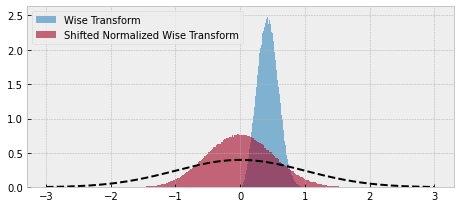

In [19]:
# Set parameters
a = 1
n = 50000
k = 10

# Sample standard normal and transform
S = np.random.randn(n, 1) * sd_S

# Sample Dirichlet
y = symdirchlet_beta_sampling(a, k, size=n)
y = get_last_symdirichlet(y)

# Wise Transform
z_w = wise_transform(1 - y) 
z_ws = (z_w - wise_mean((k-1) * a, a)) / prop_wise_sd((k-1) * a, a) + S

# Plot approximations and PDF of standard normal
plt.hist(z_w.reshape(k * n), label='Wise Transform', **kwargs)
plt.hist(z_ws.reshape(k * n), label='Shifted Normalized Wise Transform', **kwargs)
_x = np.linspace(-3, 3, 1000)
plt.plot(_x, norm.pdf(_x), '--', color='black')

plt.legend();
#plt.savefig(f'./figures/naive_softmax_approx_k{k}_a{a}.pdf')
plt.tight_layout()

In [20]:
print(f'Empirical mean: {np.mean(z_w):6.4f}')
print(f'Wise mean:      {wise_mean((k-1) * a, a):6.4f}')
print(f'Empirical sd:   {np.std(z_w, ddof=1):6.4f}')
print(f'Wise sd (prop): {prop_wise_sd((k-1) * a, a):6.4f}')

Empirical mean: 0.4294
Wise mean:      0.4273
Empirical sd:   0.1559
Wise sd (prop): 0.4807


The mean turns out to be very accurate, though the proportional standard deviation is not accurate enough for practical application. In our case, the prior is given by $B(\alpha, (k-1)\alpha)$ which simplifies things considerably. We note that as $k\alpha > \alpha$ we apply the symmetrical transform, so we will in effect be dealing with $B((k-1)\alpha, \alpha)$. We want to firstly, verify the proportionality, and if this holds, find better estimates for the true standard deviation. 

The first step is to verify proportionality. Accounting for $\beta > \alpha$ in a symmetric Dirichlet distribution, we have $N = (k-1)\alpha + \frac{\alpha}{2} - \frac{1}{2}$. Wise states that the standard deviation is proportional to 

$$
\begin{align}
\sigma_z &\propto \frac{1}{\sqrt[6]{\alpha}\sqrt[3]{ N}}
\end{align}
$$

We test this by sampling the distribution with varying $k,\alpha$ and plotting the empirical and proportional standard deviations with the goal of estimating the coefficients of the cube roots.

  0%|          | 0/251 [00:00<?, ?it/s]

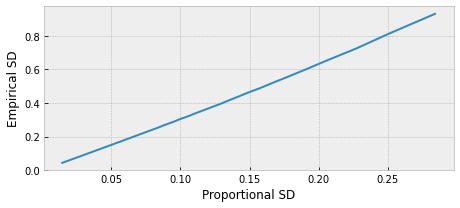

In [21]:
n = 10000
_ks = np.arange(5,256)
_as = np.linspace(.5, 13, 251)

emp_sds = []
prop_sds = []

i = 0
for k, a in tqdm(list(zip(_ks, _as))):
    y = symdirchlet_beta_sampling(a, k, size=n)
    S = np.random.randn(n, 1) * (prop_wise_sd((k-1)*a, a) - sd_S)
    y = get_last_symdirichlet(y)
    z_w = wise_transform(1 - y)
    emp_sds += [np.std(z_w, ddof=1)]
    prop_sds += [prop_wise_sd((k-1)*a, a)]
    
prop_sds = np.array(prop_sds)
emp_sds = np.array(emp_sds)

plt.plot(emp_sds, prop_sds)
plt.xlabel("Proportional SD");
plt.ylabel("Empirical SD");

In [22]:
X = np.hstack([np.ones_like(prop_sds[:,None]), prop_sds[:,None]])
y = emp_sds[:,None]

theta = (np.linalg.inv(X.T @ X) @ X.T @ y).T[0]
theta

array([0.00158384, 0.31548415])

It looks as if we have a constant $\theta \approx 0.315$, and a small shift $\theta_0 \approx .001$. We specify that the normal approximation improves for higher values of $\alpha$, and that $\alpha \geq 0.5$ for this particular approximation.

In [23]:
def wise_sd(a, b, theta=0.32, theta0=0.001):
    '''Calculates an estimate of the standard deviation of the Wise transform. 
    '''    
    return theta * prop_wise_sd(a, b) + theta0

  0%|          | 0/101 [00:00<?, ?it/s]

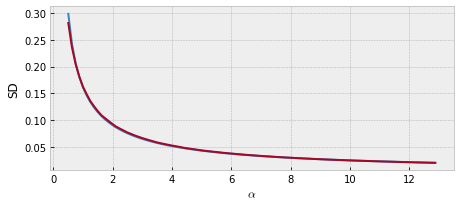

In [24]:
n = 5000
_ks = np.arange(5,106)
_as = np.linspace(.5, 12.875, 101)

emp_sds = []
prop_sds = []

i = 0
for k, a in tqdm(list(zip(_ks, _as))):
    y = symdirchlet_beta_sampling(a, k, size=n)
    y = get_last_symdirichlet(y)
    S = np.random.randn(n, 1) * (prop_wise_sd((k-1)*a, a) - sd_S)
    z_w = wise_transform(1 - y)
    emp_sds += [np.std(z_w, ddof=1)]
    prop_sds += [wise_sd((k-1)*a, a)]
    
prop_sds = np.array(prop_sds)
emp_sds = np.array(emp_sds)

fig, ax = plt.subplots()
ax.plot(_as, prop_sds)
ax.plot(_as, emp_sds)
plt.xlabel(r"$\alpha$");
plt.ylabel("SD");

We now have a decent estimate of the standard deviation, and the inverse Dirichlet-Softmax transform is thus given by

$$
\begin{align}
Z_i = \frac{\sqrt[3]{-\ln(1 - Y_i)} - \mu_Z}{\sigma_Z} + S - \mu_S \sim \mathcal N(0, 1)
\end{align}
$$

where

$$
\begin{align}
1 < k &\in \mathbb N \\
0.5 \leq \alpha &\in \mathbb R \\
Y &\sim \text{SymDirichlet}(\alpha, k) \\
\sigma_S^2 &= \ln\bigg(\frac{e - 1}{k} + 1\bigg) \\
\mu_S &= \ln(k) + \frac{1-\sigma_S^2}{2} \\
S &\sim \mathcal N (\mu_S, \sigma_S^2) \\
N &=  (k-1)\alpha + \frac{\alpha - 1}{2} \\
\mu_Z &= \alpha^{1/3}\bigg(1-\frac{1}{9\alpha}\bigg)\bigg(N - \frac{(\alpha-1)(\alpha + \frac{1}{3})}{12N} \bigg) \\
\sigma_Z &=  \frac{\theta}{\sqrt[6]{\alpha} \sqrt[3]{N}} + \theta_0. \\
\end{align}
$$


In [25]:
def wise_marlow_transform(y, a, k, S=None, theta=0.32, theta0=0.001):
    ''' Applies the full Wise-Marlow inverse softmax transform.
    '''
    N = (k-1) * a + a / 2 - 1 / 2
    
    part1 = np.cbrt(a) * (1 - 1/(9 * a)) 
    part2 = 1 / np.cbrt(N - (a - 1) * (a + 1/3) / (12 * N**2))
    mu_Z = part1 * part2

    sd_Z = theta * 1 / (a**(1/6) * N**(1/3)) + theta0
    
    wise = (np.cbrt(-np.log(1 - y)) - mu_Z) / sd_Z
    
    var_S = np.log((np.exp(1) - 1) / k + 1)
    #mu_S = np.log(k) + 1/2 - var_S/2

    if S is None:
        S = np.random.randn(len(y), 1) * np.sqrt(var_S)
    
    return wise + S

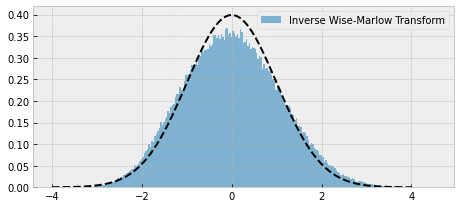

In [26]:
# Set parameters
a = 1
n = 20000
k = 10

# Sample standard normal and transform
S = np.random.randn(n, 1) * sd_S

# Sample Dirichlet
y = symdirchlet_beta_sampling(a, k, size=n)
y = get_last_symdirichlet(y)

# Wise Transform
#z_w = (wise_transform(1 - y) - wise_mean((k-1) * a, a)) / wise_sd((k-1) * a, a) + S - mu_S
z_w = wise_marlow_transform(y, a, k)

# Plot approximations and PDF of standard normal
plt.hist(z_w.reshape(k * n), label='Inverse Wise-Marlow Transform', **kwargs)
_x = np.linspace(-4, 4, 1000)
plt.plot(_x, norm.pdf(_x), '--', color='black')

plt.legend();
plt.savefig(f'../figures/misc/inverse_wise_marlow_transform_k{k}_a{a}.pdf')
plt.tight_layout()

The inverse Wise-Marlow transform is an inverse Softmax approximation from a set of $k-1$ Dirichlet distributed variables. However, a forward Wise-Marlow transform to transform a set of Gaussian variables to Dirichlet would also be extremely useful for our purposes. For the general Beta case we have

$$
\begin{align}
Y_i = 1 - \exp\Big( - \big(\sigma_Z(Z_i - S + \mu_S) + \mu_Z \big)^3 \Big) \sim \text{Beta}(\alpha, (k-1)\alpha),
\end{align}
$$

however we would like this to be symmetrically Dirichlet. From before we saw that a Dirichlet can be sampled via a set of beta distributed variables. Recall that

$$
\begin{align}
U_i &\sim B(\alpha, (k-i)\alpha) \\
Y_i &= U_i \prod_{j<i} (1 - U_j) \\
\end{align}
$$

To see the inverse of this string clipping sampling procedure, we again consider the first elements in the sequence.

$$
\begin{align}
U_1 &= Y_1 \\
U_2 &= \frac{Y_2}{1-U_1} = \frac{Y_2}{1-Y_1} \\
U_3 &= \frac{Y_3}{(1-Y_1)(1-U_2)} = \frac{Y_3}{(1-Y_1)\Big(1-\frac{Y_2}{1-Y_1}\Big)} = \frac{Y_3}{1-Y_1-Y_2} \\
U_4 &= \frac{Y_4}{(1-Y_1)(1-U_2)(1-U_3)} = \dots = \frac{Y_4}{1-Y_1-Y_2-Y_3}, \\
\end{align}
$$

so the $U_i$s can be recovered by
$$
\begin{align}
U_i &= \frac{Y_i}{1-\sum_{j<i}Y_j}.
\end{align}
$$

This means that the Dirichlet distribution has a bijective relationship with independent random variables with a Beta distribution by a triangular relation, which is somewhat surprising. In other words, the Dirichlet sampling from beta random variables is bijective. 

To forward transform from standard normal distributed variables to a Dirichlet would thus require individual parameters $\mu_{Z_i}, \sigma_{Z_i}$ to be calculated from a decreasing sequence $k_i = k-i$ for $1 < i < k$. We then need to calculate a sequence of parameters $\sigma_Z = \big( \sigma_{Z_i} : i=1,\dots, k-1 \big)$ and a similar sequence for $\mu_Z$.  We implement this as well as a modified vectorized transform to retrieve beta-distributed rvs. in the correct form to perform a Dirichlet sample.

In [27]:
def WMT_params(a, k, theta=0.32, theta0=0.001):
    '''Get vectorized parameters for Wise-Marlow forward transform.
    '''
    ks = np.arange(k, 1, -1)
    N = (ks - 1) * a + a / 2 - 1 / 2
    
    part1 = np.cbrt(a) * (1 - 1/(9 * a)) 
    part2 = 1 / np.cbrt(N - (a - 1) * (a + 1/3) / (12 * N**2))
    
    mu_Z = part1 * part2
    sd_Z = theta * 1 / (a**(1/6) * N**(1/3)) + theta0

    return mu_Z[None,:], sd_Z[None,:]


def WMT_US(z, a, k, clip=False):
    '''Transforms a set of normally distributed variables for Dirichlet transform.
    '''
    _z = z[:,:-1]
    _z0 = z[:,-1][:,None]
    
    mu_Z, sd_Z = WMT_params(a, k)

    var_S = np.log((np.exp(1) - 1) / k + 1)
    mu_S = np.log(k) + 1/2 - var_S/2

    S = _z0 * np.sqrt(var_S)

    U = 1 - 1 / np.exp( ( sd_Z * (_z - S) + mu_Z )**3 )
    
    return (U, S) if not clip else (np.clip(U, 0, 1), S)



def WMT_Z(U, S, a, k):
    '''Transforms a set of beta distributed variables with a Marlow variable to standard normal.
    '''
    mu_Z, sd_Z = WMT_params(a, k)

    var_S = np.log((np.exp(1) - 1) / k + 1)
    mu_S = np.log(k) + 1/2 - var_S/2
    
    wt = (np.cbrt(-np.log(1 - U)) - mu_Z) / sd_Z
    z = wt + S
    
    z0 = S / np.sqrt(var_S)
    
    return np.hstack([z, z0])


def beta2dirichlet(u):
    '''Perform the Beta->Dirichlet transform.
    '''
    y = np.zeros_like(u)
    y[:,0] = u[:,0]
    y[:,1:] = np.cumprod(1-u[:,:-1], axis=-1) * u[:,1:]
    return y


def dirichlet2beta(y):
    '''Perform the Dirichlet->Beta transform.
    '''
    u = np.zeros_like(y)
    u[:,0] = y[:,0]   
    u[:,1:] = y[:,1:] / (1 - np.cumsum(y[:,:-1], axis=-1))
    return u

-0.021951755656591354 0.9992784836316784
2.8102903902026788e-05 0.9978575253146433


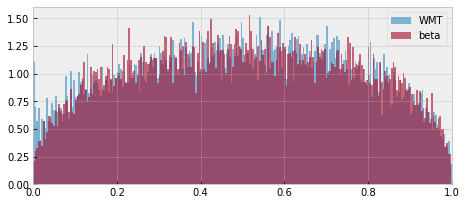

In [28]:
n = 20000
_z = np.random.randn(n, k)
a = 1.4

U, S = WMT_US(_z, a, k, clip=False);

_as = a * np.ones((n, (k-1)))
_bs = a * np.arange(k-1, 0, -1)

Ub = np.random.beta(_as, _bs)


print(np.min(U), np.max(U))
print(np.min(Ub), np.max(Ub))
plt.xlim(0,1)
i = 8
plt.hist(U[:,i][U[:,i] > 0], **kwargs, label='WMT');
plt.hist(Ub[:,i], **kwargs, label='beta');
plt.legend();

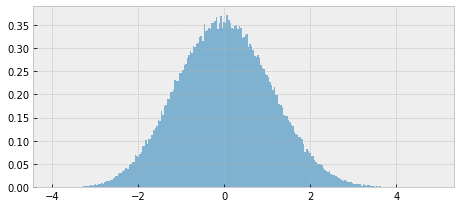

In [29]:
plt.hist(WMT_Z(Ub, S, a, k).reshape(k*n), **kwargs);

In [30]:
def WMT_fwd(Z, a, k, clip=True):
    '''Performs the forward Wise-Marlow softmax transform.
    '''
    U, S = WMT_US(Z, a, k, clip=clip)
    Y = beta2dirichlet(U)
    return Y, S

def WMT_inv(Y, S, a, k):
    '''Performs the inverse Wise-Marlow softmax transform.
    '''
    U = dirichlet2beta(Y)
    Z = WMT_Z(U, S, a, k)
    return Z

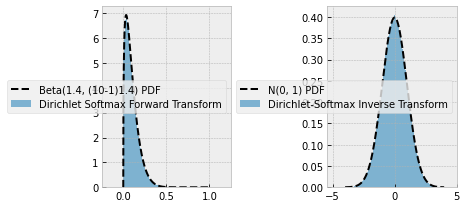

In [31]:
# Set parameters
a = 1.4
n = 50000
k = 10

# Sample standard normal
Z = np.random.randn(n, k)

# Forward WM Transform
Y, S = WMT_fwd(Z, a, k, clip=False)

# Inverse WM Transform
Zh = WMT_inv(Y, S, a, k)

fig, axs = plt.subplots(1, 2)

# Plot Dirichlet / Beta approximations
axs[0].hist(np.clip(get_last_symdirichlet(Y), 0, 1).reshape((k) * n), label='Dirichlet Softmax Forward Transform', **kwargs)
_x = np.linspace(0, 1, 1000)
axs[0].plot(_x, beta.pdf(_x, a, (k-1)*a), '--', color='black', label=f'Beta({a}, ({k}-1){a}) PDF')
axs[0].set_xlim(-.25, 1.25)

# Plot Gaussian approximations
axs[1].hist(Zh.reshape((k) * n), label='Dirichlet-Softmax Inverse Transform', **kwargs)
_x = np.linspace(-4, 4, 1000)
axs[1].plot(_x, norm.pdf(_x), '--', color='black', label='N(0, 1) PDF')

axs[0].legend();
axs[1].legend();
plt.savefig(f'../figures/misc/wise_marlow_transform_full_k{k}_a{a}.pdf')
plt.tight_layout()